## Load the data

In [1]:
# !pip install adjustText
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib as mpl
from scipy.interpolate import make_interp_spline, BSpline
from adjustText import adjust_text

pd.set_option('mode.chained_assignment', None)
%config InlineBackend.figure_format = 'retina'

In [2]:
colors = {
    'ARI':'#97233F',
    'ATL':'#A71930',
    'BAL':'#241773',
    'BUF':'#00338D',
    'CAR':'#0085CA',
    'CHI':'#C83803',
    'CIN':'#FB4F14',
    'CLE':'#311D00',
    'DAL':'#041E42',
    'DEN':'#FB4F14',
    'DET':'#0076B6',
    'GB' :'#203731',
    'HOU':'#03202F',
    'IND':'#002C5F',
    'JAX':'#006778',
    'KC' :'#E31837',
    'LAC':'#0080C6',
    'LAR':'#866D4B',
    'MIA':'#008E97',
    'MIN':'#4F2683',
    'NE' :'#002244',
    'NO' :'#D3BC8D',
    'NYG':'#0B2265',
    'NYJ':'#125740',
    'OAK':'#A5ACAF',
    'PHI':'#004C54',
    'PIT':'#FFB612',
    'SEA':'#69BE28',
    'SF' :'#AA0000',
    'TB' :'#D50A0A',
    'TEN':'#0C2340',
    'WAS':'#773141'
}

kc_p = '#E31837'
kc_s = '#FFB81C'

In [3]:
data = pd.read_csv('clean_pbp_2019_wk19.csv',low_memory=False)
roster = pd.read_csv('roster_2009_2019.csv',low_memory=False)

# Analysis

In [4]:
#changing interceptions to incomplete passes
data.loc[data['interception']==1, 'complete_pass'] = 0
#Getting the cpoe variable
data['cpoe'] = data['complete_pass'] - data['cp']

In [5]:
#Fixing old naming conventions
data.loc[(data['posteam']=='LA'),'posteam'] = 'LAR'
data.loc[(data['posteam']=='SD'),'posteam'] = 'LAC'
data.loc[(data['posteam']=='JAC'),'posteam'] = 'JAX'
data.loc[(data['posteam']=='STL'),'posteam'] = 'LAR'

roster.loc[(roster['team']=='LA'),'team'] = 'LAR'
roster.loc[(roster['team']=='SD'),'team'] = 'LAC'
roster.loc[(roster['team']=='JAC'),'team'] = 'JAX'
roster.loc[(roster['team']=='STL'),'team'] = 'LAR'

In [6]:
#Doing a really pointless thing to match on just one variable instead of matching on all 3, don't ask me why I did this
roster['roster_id'] = roster['season'].astype(str) + \
'_' + \
roster['abbr_player_name'] + \
'_' +\
roster['team']

data['roster_id'] = data['season'].astype(str) + '_' +\
data['receiver_player_name'] + '_' + data['posteam']

## Games

In [7]:
#merge roster with play by play to get players' position
merged_data = pd.merge(data, roster, on='roster_id')
#Just get Tight Ends
tes_pbp = merged_data.loc[(merged_data['position']=='TE')]
tes_pbp.drop_duplicates(inplace=True)
#Group tight ends by name and team - we don't use this for this analysis
tes = tes_pbp.groupby(by=['receiver_player_name','posteam'])['epa','success','air_yards','cpoe','yards_after_catch'].mean()
tes[['total_epa','total_wpa']] = tes_pbp.groupby(by=['receiver_player_name','posteam'])['epa','wpa'].sum()
#Group the tight end performances by game
tes_game = tes_pbp.groupby(by=['receiver_player_name','posteam','alt_game_id','week'])['epa','wpa','yards_gained','air_yards','yards_after_catch'].sum()
tes_game['success'] = tes_pbp.groupby(by=['receiver_player_name','posteam','alt_game_id','week'])['success'].mean()
tes_game['attempts'] = tes_pbp.groupby(by=['receiver_player_name','posteam','alt_game_id','week'])['epa'].count()

#You can change number of attempts at which to cutoff here
attempt_cutoff = 1
tes_game.reset_index(inplace=True)
tes_game = tes_game.loc[(tes_game['attempts']>=attempt_cutoff) & (tes_game['week']>=18)]

In [11]:
#sorting by EPA
tes_game.sort_values(by='epa',ascending=False,inplace=True)
tes_game.head(10)

,receiver_player_name,posteam,alt_game_id,week,epa,wpa,yards_gained,air_yards,yards_after_catch,success,attempts
9900,T.Kelce,KC,2019_19_HOU_KC,19,16.816043,0.398282,134.0,79.0,64.0,0.714286,14
8808,R.Gronkowski,NE,2011_19_DEN_NE,19,12.905108,0.121333,145.0,113.0,53.0,0.750000,12
4072,G.Olsen,CAR,2015_19_SEA_CAR,19,12.857784,0.113682,77.0,51.0,26.0,1.000000,6
10186,V.Davis,SF,2011_19_NO_SF,19,12.817714,1.279107,180.0,128.0,67.0,0.600000,10
5274,J.Graham,NO,2011_19_NO_SF,19,10.243790,0.583039,103.0,65.0,50.0,0.555556,9
10696,Z.Ertz,PHI,2017_21_PHI_NE,21,9.646825,0.460523,67.0,76.0,22.0,0.777778,9
10848,Z.Miller,SEA,2012_19_SEA_ATL,19,9.641656,0.154130,142.0,123.0,46.0,0.888889,9
10204,V.Davis,SF,2012_20_SF_ATL,20,9.634859,0.293989,106.0,80.0,41.0,0.750000,8
5130,J.Finley,GB,2009_18_GB_ARI,18,9.121365,0.169640,159.0,127.0,65.0,0.666667,9
9669,T.Gonzalez,ATL,2012_20_SF_ATL,20,8.670545,0.287706,78.0,58.0,20.0,0.750000,8


### Plotting

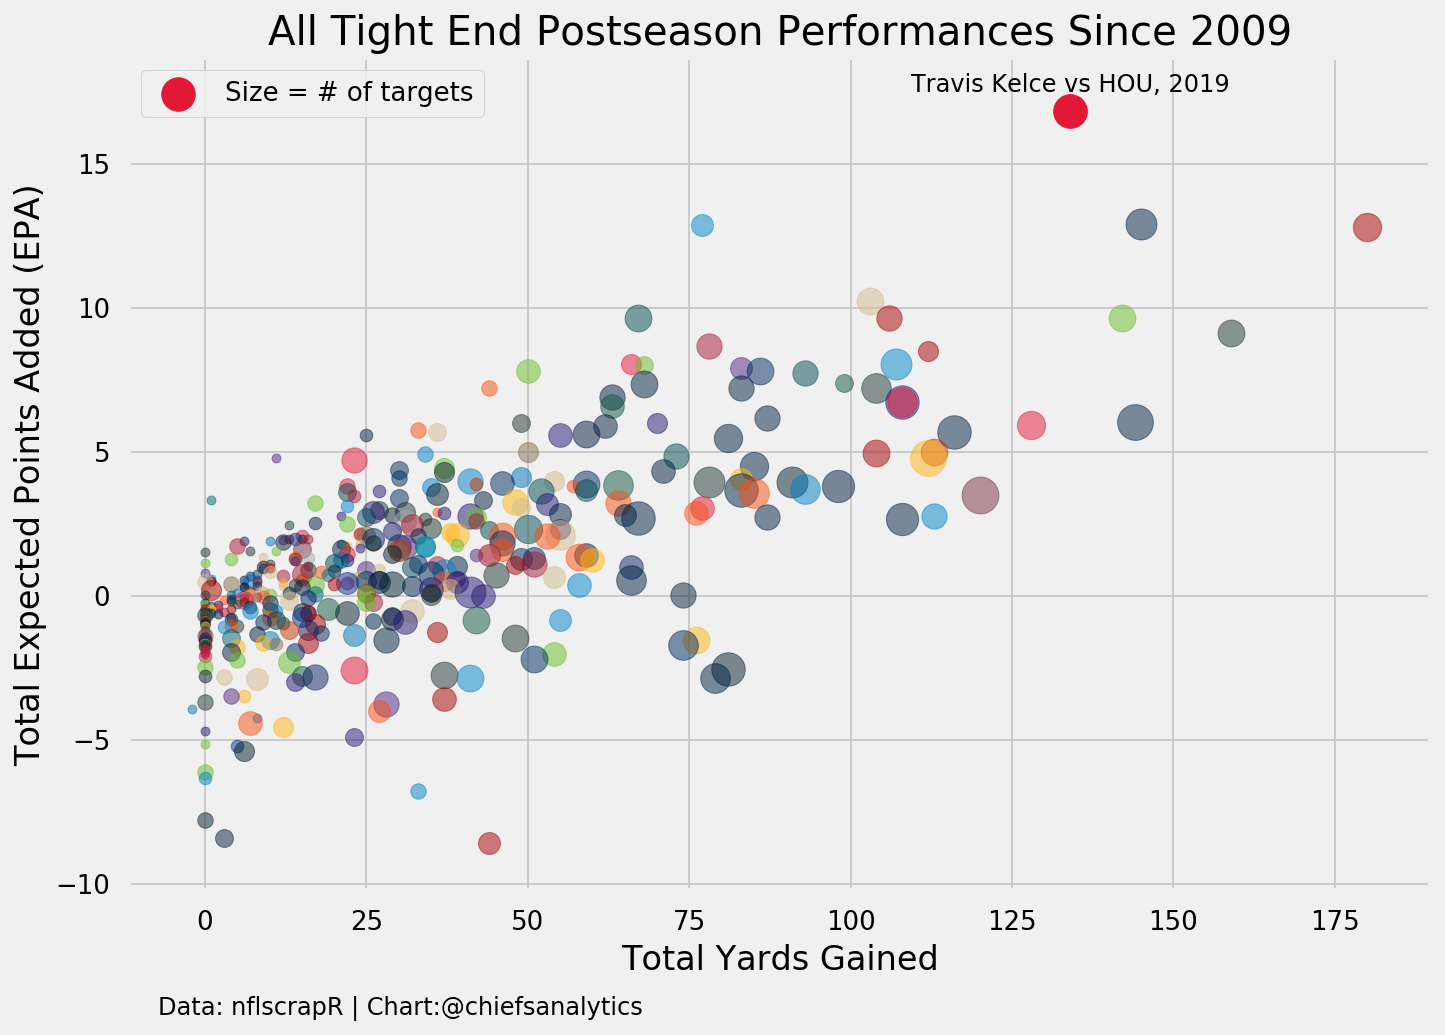

In [9]:
#Styles
plt.style.use('seaborn-talk')
plt.style.use('fivethirtyeight')

#I want to plot Kelce differently, so I grab his row
kelce = tes_game.iloc[0]
#plotting loop, useful for plotting team colors from our team colors dict
for index,te in tes_game.iterrows():
    plt.scatter(te['yards_gained'], te['epa'], c=colors[te['posteam']], 
                s=te['attempts']*20, alpha=0.5)

#Plot Kelce
plt.scatter(kelce['yards_gained'],kelce['epa'], c=kc_p, s=kelce['attempts']*20,label='Size = # of targets')
#Annotate his name
plt.annotate('Travis Kelce vs HOU, 2019',
            (kelce['yards_gained'],kelce['epa']),
            textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',fontsize = 12)
#Titles and lables
plt.title('All Tight End Postseason Performances Since 2009')
plt.ylabel('Total Expected Points Added (EPA)')
plt.xlabel('Total Yards Gained')
txt = "Data: nflscrapR | Chart:@chiefsanalytics"
plt.figtext(0.1, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=12)
plt.legend(loc='upper left')